# Generative Models for Text

DSCI 552 | Machine Learning for Data Science

Homework 7

Matheus Schmitz

USC ID: 5039286453

In [1]:
# OS
import os

# Py Data Stack
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt

# Tensor Flow & Keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from tensorflow.keras.optimizers import Adam, Nadam

# String Manipulation
import string

# Progress Bar
from tqdm import tqdm

# Disable warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Making sure Tensor Flow is properly working with GPU
print('Available Devices:')
for device in tf.config.experimental.list_physical_devices():
    print(device)
print()
print(f'TensorFlow using GPU: {tf.test.is_gpu_available()}')
print(f'TensorFlow using CUDA: {tf.test.is_built_with_cuda()}')
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Oh boy, there's no GPU, so prepare yourself for a long wait :(")
print()
try:
    !nvcc --version
except:
    print('ooops, watch out, something went wrong!')
print()
try:
    !nvidia-smi
except:
    print('ooops, watch out, something went wrong!')

Available Devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU')

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TensorFlow using GPU: True
TensorFlow using CUDA: True
Num GPUs Available:  1
Default GPU Device: /device:GPU:0

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2019 NVIDIA Corporation
Built on Sun_Jul_28_19:12:52_Pacific_Daylight_Time_2019
Cuda compilation tools, release 10.1, V10.1.243

Tue Nov 24 19:08:02 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 446.14       Driver Version: 446.14       CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp

## (a) Project Goal

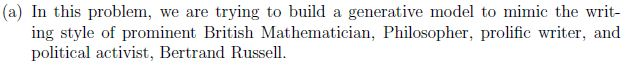

## (b) Source Data

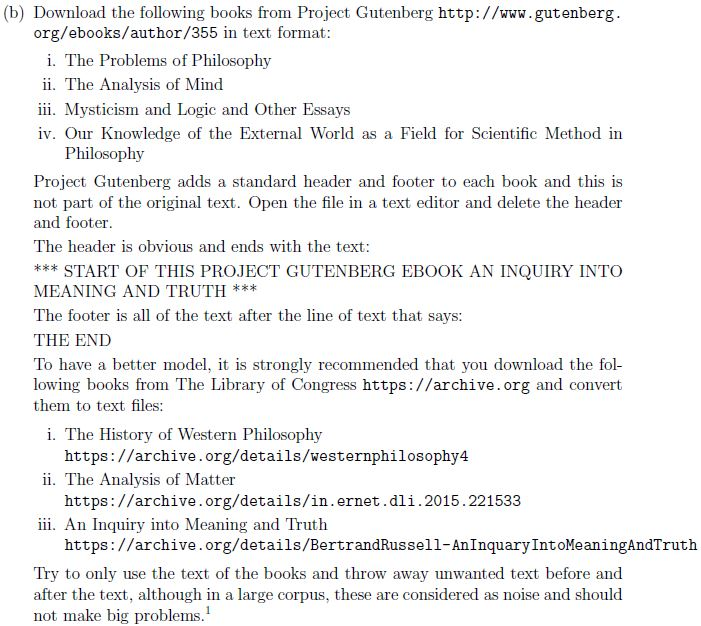

In [3]:
BOOKS_PATH = '../data/books/'
BOOK_TXTS = os.listdir(BOOKS_PATH)
BOOK_TXTS

['AIIMAT.txt',
 'MLOE.txt',
 'OKEWFSMP.txt',
 'TAM.txt',
 'TAMatter.txt',
 'THWP.txt',
 'TPP.txt']

## (c) LSTM Mimicking Russell's Style and Thoughts


### (i) Create Corpus

In [4]:
# Path to the corpus 
CORPUS_PATH = 'Corpus.txt'

# Create a single corpus with all files
with open(CORPUS_PATH, 'w') as concatenated_corpus:
    for book in BOOK_TXTS:
        with open(BOOKS_PATH+book, 'r', encoding='ascii', errors='ignore') as txt_file:
            for line in txt_file:
                concatenated_corpus.write(line)
                
# Store the corpus in a file
CORPUS = open(CORPUS_PATH, 'r').read()
print(f'There are {len(CORPUS)} characters in the corpus')

There are 5095252 characters in the corpus


### (ii) Character-Level Representation

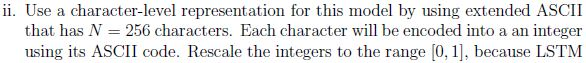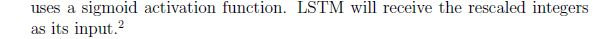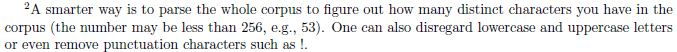

In [5]:
# Clean the corpus
CORPUS_CLEAN = np.copy(CORPUS).tolist()
CORPUS_CLEAN = CORPUS_CLEAN.lower()
CORPUS_CLEAN = CORPUS_CLEAN.translate(str.maketrans('', '', string.punctuation))

# Clean some memory - it'll be needed
del CORPUS

# Get all unique characters for mapping to extended ENCODING
UNIQUE_CHARS = set(CORPUS_CLEAN)

# Dictionaries to store the character-ENCODING mappings
CHAR_to_ENCODING = {}
ENCODING_to_CHAR = {}
CHAR_to_ENCODING_normalized = {}
ENCODING_to_CHAR_normalized = {}

# Create ENCODING encodings
VECTOR_LENGTH = len(UNIQUE_CHARS)-1
for index, char in enumerate(sorted(UNIQUE_CHARS)):
    CHAR_to_ENCODING[char] = index
    ENCODING_to_CHAR[index] = char
    CHAR_to_ENCODING_normalized[char] = index/VECTOR_LENGTH
    ENCODING_to_CHAR_normalized[index/VECTOR_LENGTH] = char

### (iii) Define Window Size

In [6]:
WINDOW_SIZE = 100

### (iv) Generating Features

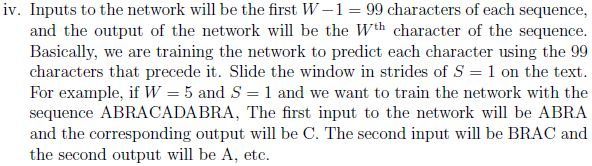

In [7]:
# Lists for the features and labels
X = []
Y = []

# Loop through the CORPUS_CLEAN generating features
for i in tqdm(range(len(CORPUS_CLEAN)-WINDOW_SIZE)):
    
    # Extract the X and Y characters
    x_chars = CORPUS_CLEAN[i: i+WINDOW_SIZE-1]
    y_char = CORPUS_CLEAN[i+WINDOW_SIZE-1]
    
    # Encode X to the normalized [0,1] range and Y to the unnormalized range (so that Y can later be one-hot encoded)
    x_encodings = [CHAR_to_ENCODING_normalized[char] for char in x_chars]
    y_encoding = [CHAR_to_ENCODING[char] for char in y_char]
    
    # Add the feature and label to X and Y
    X.append(x_encodings)
    Y.append(y_encoding)

100%|█████████████████████████████| 4942255/4942255 [01:20<00:00, 61723.76it/s]


### (v) One-Hot Encoding

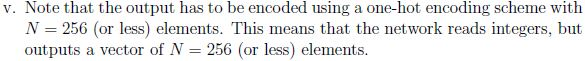

In [8]:
# Onehot encode Y
Y_onehot = tf.keras.utils.to_categorical(Y)
Y_onehot.shape

(4942255, 38)

In [9]:
# Need to reshape X so it matches Y's shape
X = np.reshape(X, (Y_onehot.shape[0], WINDOW_SIZE-1, 1))
X.shape

(4942255, 99, 1)

### (vi) / (vii) Neural Network

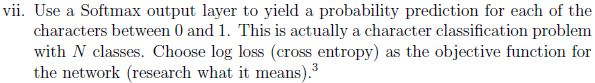

In [10]:
NEURONS = WINDOW_SIZE

# Keras Sequential Model
model_1 = Sequential()
model_1.add(LSTM(units=NEURONS, input_shape=(X.shape[1], X.shape[2]), return_sequences=False))
model_1.add(Dense(Y_onehot.shape[1], activation='softmax'))

# Objective Function
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Check model
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 38)                3838      
Total params: 44,638
Trainable params: 44,638
Non-trainable params: 0
_________________________________________________________________


### (viii) / (ix) / (x) Train Model

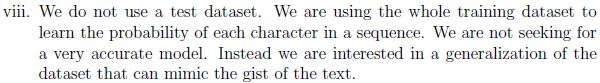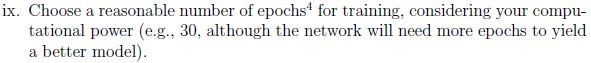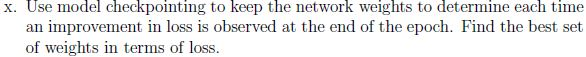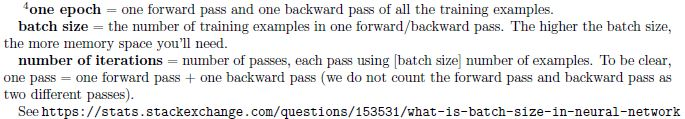

In [11]:
# Set to true to continue the model's training using the pre-trained neurons - THIS WILL GIVE AN ERROR IF THE WINDOW_SIZE OR NEURONS WAS CHANGED
# Set to false to train the neural network from scratch - THIS WILL LOSE ALL PROGRESS AND CAUSE WORSE PREDICTIONS
LOAD_TRAINED_WEIGHTS = True

if LOAD_TRAINED_WEIGHTS and os.path.exists('./checkpoints/model_1.hdf5'):

    # Try loading weights. Will fail if the model structure changed
    try:
        
        # Load best model weights
        model_1.load_weights('./checkpoints/model_1.hdf5')

        # Objective Function
        model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

        # Check model
        model_1.summary()

        # Variable to guide the csv log callback
        SUCCESSFUL_WEIGHT_LOAD = True

    except:
        SUCCESSFUL_WEIGHT_LOAD = False
        print('Could not load weights. Most likely the network architecture changed.')

else:
    SUCCESSFUL_WEIGHT_LOAD = False
    if LOAD_TRAINED_WEIGHTS:
        print('Could not locate file with weights.')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 38)                3838      
Total params: 44,638
Trainable params: 44,638
Non-trainable params: 0
_________________________________________________________________


In [12]:
EPOCHS = 30
BATCH_SIZE = 256
TRAIN_MODEL = False

if TRAIN_MODEL:

    # Define directory for model checkpoints
    BACKUP_DIR = './checkpoints'
    if not os.path.exists(BACKUP_DIR):
        os.mkdir(BACKUP_DIR)
        
    # Define file to store checkpoint
    BACKUP_FILE = os.path.join(BACKUP_DIR, 'model_1.hdf5')

    # Callbacks
    checkpoint = ModelCheckpoint(BACKUP_FILE, 
                                monitor='loss',
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=0)
    plateauLRreduce = ReduceLROnPlateau(factor = 0.5,
                                        patience = 10,
                                        monitor='loss',
                                        min_lr = 0.0000001,
                                        verbose=1)
    stopearly = EarlyStopping(monitor='loss',
                            patience=15,
                            verbose=1)
    logCSV = CSVLogger(filename='log_model_1.csv',
                    separator=',', 
                    append=(LOAD_TRAINED_WEIGHTS & SUCCESSFUL_WEIGHT_LOAD)) 

    model_callbacks = [checkpoint, plateauLRreduce, stopearly, logCSV]

    # Train model and save history
    model_history = model_1.fit(X,
                                Y_onehot,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                callbacks=model_callbacks,
                                shuffle=True)
    
else:
    if SUCCESSFUL_WEIGHT_LOAD:
        print('Skipping model training. Using loaded weights without further training.')
    else:
        print('Skipping model training. Yet, could not load trained weights. THIS IS AN UNTRAINED MODEL UNSUITABLE FOR MAKING PREDICTIONS.')

Skipping model training. Using loaded weights without further training.


### (xi) Generate 1000 Characters

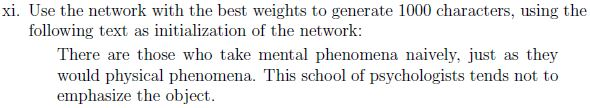

In [13]:
# Load best model weights
model_1.load_weights('./checkpoints/model_1.hdf5')

# Objective Function
model_1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Check model
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               40800     
_________________________________________________________________
dense (Dense)                (None, 38)                3838      
Total params: 44,638
Trainable params: 44,638
Non-trainable params: 0
_________________________________________________________________


In [14]:
# Base text
base_text = 'There are those who take mental phenomena naively, just as they would physical phenomena. This school of psychologists tends not to emphasize the object.'
print(f'Lenght of base test before pre-processing: {len(base_text)}')

### PRE-PROCESSING ###

# Clean the corpus
base_text = np.copy(base_text).tolist()
base_text = base_text.lower()
base_text = base_text.translate(str.maketrans('', '', string.punctuation))

# Encode
x_chars = base_text[0: len(base_text)]

# Encode X to the normalized [0,1] range and Y to the unnormalized range (so that Y can later be one-hot encoded)
x_encodings = [CHAR_to_ENCODING_normalized[char] for char in x_chars]

# Add the feature to X_text
X_text = x_encodings

# Reshape
# Need to reshape X so it matches Y's shape
X_text = np.reshape(x_encodings, (1, len(x_encodings), 1))

print(f'Lenght of base test after pre-processing: {X_text.shape[1]}')

Lenght of base test before pre-processing: 153
Lenght of base test after pre-processing: 150


In [15]:
# Generating text
synthetic_text = X_text.copy()
synthetic_text = synthetic_text.flatten()

# Generate 1000 words
for i in tqdm(range(1000)):
    
    # Get synthetic_text to the needed input shape
    input_text = np.reshape(synthetic_text[-(WINDOW_SIZE-1):], (1, WINDOW_SIZE-1, 1))
    
    # Get predicted probabilities for each character
    pred = model_1.predict(input_text)
    
    # Select the index of the most likely character
    pred_idx = np.argmax(pred)
    
    # Use that index to retrieve the character
    pred_normalized = pred_idx/VECTOR_LENGTH
    
    # Add the prediction to the synthetic text
    synthetic_text = np.append(synthetic_text, pred_normalized)

# Once all characters have been predited, transform back to letters
predicted_text = [ENCODING_to_CHAR_normalized[encoding] for encoding in synthetic_text]

# Then concatenate all letters to form the text
predicted_text = ''.join(predicted_text)

# Result
print()
print(predicted_text)

100%|██████████████████████████████████████| 1000/1000 [01:35<00:00, 10.46it/s]


there are those who take mental phenomena naively just as they would physical phenomena this school of psychologists tends not to emphasize the object is the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the semse the s

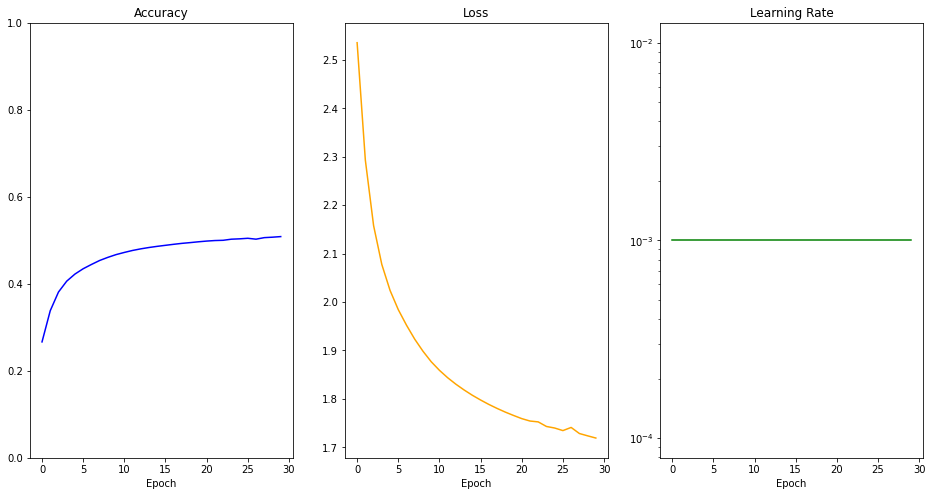

In [16]:
# Read the log file
log_model_1 = pd.read_csv('log_model_1.csv')

# Create figure
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,8))

# Accuracy
fig.sca(axs[0])
g = plt.plot(log_model_1.index, log_model_1.accuracy, color='blue')
axs[0].set_ylim([0, 1])
axs[0].title.set_text('Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_xlabel('Epoch')

# Loss
fig.sca(axs[1])
g = plt.plot(log_model_1.index, log_model_1.loss, color='orange')
axs[1].title.set_text('Loss')
axs[1].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')

# Learning Rate
fig.sca(axs[2])
axs[2].set_yscale('log')
g = plt.plot(log_model_1.index, log_model_1.lr, color='green')
axs[2].title.set_text('Learning Rate')
axs[2].set_xlabel('Epoch')
axs[2].set_xlabel('Epoch')

plt.show()

### (xii) Deeper Neural Network

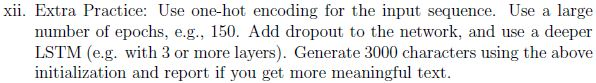

In [17]:
NEURONS = WINDOW_SIZE

# Keras Sequential Model
model_2 = Sequential()
model_2.add(LSTM(units=NEURONS, input_shape=(X.shape[1], X.shape[2]), return_sequences=True))
model_2.add(Dropout(0.1))
model_2.add(LSTM(units=NEURONS, return_sequences=True))
model_2.add(LSTM(units=NEURONS, return_sequences=False))
model_2.add(Dropout(0.5))
model_2.add(Dense(Y_onehot.shape[1], activation='softmax'))

# Objective Function
model_2.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

# Check model
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 99, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 99, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 99, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                3838      
Total params: 205,438
Trainable params: 205,438
Non-trainable params: 0
________________________________________________

In [18]:
# Set to true to continue the model's training using the pre-trained neurons - THIS WILL GIVE AN ERROR IF THE WINDOW_SIZE OR NEURONS WAS CHANGED
# Set to false to train the neural network from scratch - THIS WILL LOSE ALL PROGRESS AND CAUSE WORSE PREDICTIONS
LOAD_TRAINED_WEIGHTS = True

if LOAD_TRAINED_WEIGHTS and os.path.exists('./checkpoints/model_2.hdf5'):

    # Try loading weights. Will fail if the model structure changed
    try:
    
        # Load best model weights
        model_2.load_weights('./checkpoints/model_2.hdf5')

        # Objective Function
        model_2.compile(loss='categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

        # Check model
        model_2.summary()

        # Variable to guide the csv log callback
        SUCCESSFUL_WEIGHT_LOAD = True

    except:
        SUCCESSFUL_WEIGHT_LOAD = False
        print('Could not load weights. Most likely the network architecture changed')

else:
    SUCCESSFUL_WEIGHT_LOAD = False
    if LOAD_TRAINED_WEIGHTS:
        print('Could not locate file with weights')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 99, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 99, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 99, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                3838      
Total params: 205,438
Trainable params: 205,438
Non-trainable params: 0
________________________________________________

In [19]:
EPOCHS = 150
BATCH_SIZE = 512
TRAIN_MODEL = False

if TRAIN_MODEL:

    # Define directory for model checkpoints
    BACKUP_DIR = './checkpoints'
    if not os.path.exists(BACKUP_DIR):
        os.mkdir(BACKUP_DIR)
        
    # Define file to store checkpoint
    BACKUP_FILE = os.path.join(BACKUP_DIR, 'model_2.hdf5')

    # Callbacks
    checkpoint = ModelCheckpoint(BACKUP_FILE, 
                                monitor='loss',
                                save_best_only=True,
                                save_weights_only=True,
                                verbose=0)
    plateauLRreduce = ReduceLROnPlateau(factor = 0.5,
                                        patience = 5,
                                        monitor='loss',
                                        min_lr = 0.0000001,
                                        verbose=1)
    stopearly = EarlyStopping(monitor='loss',
                            patience=15,
                            verbose=1)
    logCSV = CSVLogger(filename='log_model_2.csv',
                    separator=',', 
                    append=LOAD_TRAINED_WEIGHTS)

    model_callbacks = [checkpoint, plateauLRreduce, stopearly, logCSV]

    # Train model and save history
    model_history = model_2.fit(X,
                                Y_onehot,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                callbacks=model_callbacks,
                                shuffle=True)
    
else:
    if SUCCESSFUL_WEIGHT_LOAD:
        print('Skipping model training. Using loaded weights without further training.')
    else:
        print('Skipping model training. Yet, could not load trained weights. THIS IS AN UNTRAINED MODEL UNSUITABLE FOR MAKING PREDICTIONS.')

Skipping model training. Using loaded weights without further training.


**Predict 3000 Characters**

In [20]:
# Load best model weights
model_2.load_weights('./checkpoints/model_2.hdf5')

# Objective Function
model_2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Check model
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 99, 100)           40800     
_________________________________________________________________
dropout (Dropout)            (None, 99, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 99, 100)           80400     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 38)                3838      
Total params: 205,438
Trainable params: 205,438
Non-trainable params: 0
________________________________________________

In [21]:
# Base text
base_text = 'There are those who take mental phenomena naively, just as they would physical phenomena. This school of psychologists tends not to emphasize the object.'
print(f'Lenght of base test before pre-processing: {len(base_text)}')

### PRE-PROCESSING ###

# Clean the corpus
base_text = np.copy(base_text).tolist()
base_text = base_text.lower()
base_text = base_text.translate(str.maketrans('', '', string.punctuation))

# Encode
x_chars = base_text[0: len(base_text)]

# Encode X to the normalized [0,1] range and Y to the unnormalized range (so that Y can later be one-hot encoded)
x_encodings = [CHAR_to_ENCODING_normalized[char] for char in x_chars]

# Add the feature to X_test
X_text = x_encodings

# Reshape
# Need to reshape X so it matches Y's shape
X_text = np.reshape(x_encodings, (1, len(x_encodings), 1))

print(f'Lenght of base test after pre-processing: {X_text.shape[1]}')

Lenght of base test before pre-processing: 153
Lenght of base test after pre-processing: 150


In [22]:
# Generating text
synthetic_text = X_text.copy()
synthetic_text = synthetic_text.flatten()

# Generate 1000 words
for i in tqdm(range(3000)):
    
    # Get synthetic_text to the needed input shape
    input_text = np.reshape(synthetic_text[-99:], (1, WINDOW_SIZE-1, 1))
    
    # Predict a character
    pred = model_2.predict(input_text)
    
    # Select the index of the most likely character
    pred_idx = np.argmax(pred)
    
    # Use that index to retrieve the character
    pred_normalized = pred_idx/VECTOR_LENGTH
    
    # Add the prediction to the synthetic text
    synthetic_text = np.append(synthetic_text, pred_normalized)

# Once all characters have been predited, transform back to letters
predicted_text = [ENCODING_to_CHAR_normalized[encoding] for encoding in synthetic_text]

# Then concatenate all letters to form the text
predicted_text = ''.join(predicted_text)

# Result
print()
print(predicted_text)

100%|██████████████████████████████████████| 3000/3000 [02:21<00:00, 21.27it/s]


there are those who take mental phenomena naively just as they would physical phenomena this school of psychologists tends not to emphasize the object the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the sense of the

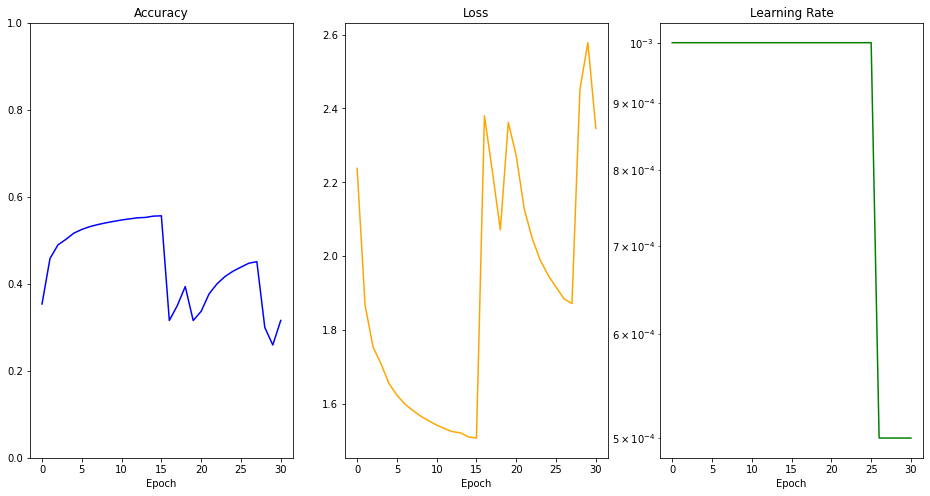

In [23]:
# Read the log file
log_model_2 = pd.read_csv('log_model_2.csv')

# Create figure
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16,8))

# Accuracy
fig.sca(axs[0])
g = plt.plot(log_model_2.index, log_model_2.accuracy, color='blue')
axs[0].set_ylim([0, 1])
axs[0].title.set_text('Accuracy')
axs[0].set_xlabel('Epoch')

# Loss
fig.sca(axs[1])
g = plt.plot(log_model_2.index, log_model_2.loss, color='orange')
axs[1].title.set_text('Loss')
axs[1].set_xlabel('Epoch')

# Learning Rate
fig.sca(axs[2])
axs[2].set_yscale('log')
g = plt.plot(log_model_2.index, log_model_2.lr, color='green')
axs[2].title.set_text('Learning Rate')
axs[2].set_xlabel('Epoch')

plt.show()

In [24]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

## The End